# Assignment 1c Notebook
This notebook builds on the EA code you wrote in Assignment 1b to guide you through implementing a constraint satisfaction EA. Therefore, you should copy over the following files:
* `base_evolution.py`
* `linear_genotype.py`
* `selection.py`
* `stock_population_evaluation.py`
* The `data` subdirectory

If you receive any feedback about the implementation of your algorithm in 1b, please address any problems before you conduct your experiment for 1c. You may also copy your previous notebooks over if you wish, but be careful to not overwrite the other files in the repo, as we may have made modifications to them.

Recall that you should be launching this notebook using the `EC-env` conda environment. If you are not in the `EC-env` environment, terminate the notebook server, activate the environment with `conda activate EC-env`, and restart the notebook server.

As usual, be sure to **read all of this notebook**. Start by executing the next cell.

In [2]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

!pip install snake-eyes-parser
!pip install pytest

import warnings
warnings.filterwarnings('ignore') # hopefully stop any pedantic warnings

import matplotlib.pyplot as plt

%matplotlib widget
plt.rcParams['figure.figsize'] = (10.0, 3.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.size'] = 8.0
plt.rcParams['figure.titlesize'] = 12.0
plt.rcParams['axes.titlesize'] = 12.0
plt.rcParams['axes.labelsize'] = 8.0
plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['savefig.dpi'] = 400.0

import multiprocessing

multiprocessing.set_start_method('fork', force=True)

import os
import statistics
from pathlib import Path
from snake_eyes import read_config
from cutting_stock.fitness_functions import *
from cutting_stock.visualizer import visualize
from stock_population_evaluation import *
from linear_genotype import LinearGenotype
from base_evolution import BaseEvolutionPopulation
from selection import *
from log_analyzer import *
from histogram import *
from stats import run_stats

print('The first cell has been executed!')

The first cell has been executed!


## Cutting Stock Constraints: Boundaries and Overlaps
Some problems, such as the cutting stock problem, have specific criteria (tangential to the main optimization objective) that a solution must obey to be considered valid; these criteria are called *constraints* on the problem. These problems are often described as optimizing for some objective *subject to the constraints*. You may recall from the lectures that there are multiple ways to handle constraints in an EA. You can employ the following techniques:
* kill invalid offspring
* feasible phenotype mapping decoder
* repair function
* feasible solution space closed under variation operators
* assign invalid solutions arbitrarily low fitness
* ignore constraints
* penalty function

In assignments 1a and 1b, we assigned invalid solutions an arbitrarily low fitness. For this assignment, we're going to guide you through the process of implementing another of these techniques: an EA using a penalty function. This technique embraces the presence of invalid solutions in your EA's population by penalizing their fitness based on how much they violate the constraints. Let's review what the constraints are in this assignment series, to understand why keeping invalid solutions around might be useful. As discussed during Assignment 1a, there are two ways for a cutting stock solution to be invalid in our implementation:
1. shapes are out-of-bounds
2. shapes are overlapping

If a solution violates these constraints, it is invalid, as you physically could not cut shapes using such a layout. **Invalid solutions do not actually solve the problem, meaning they are always worse than any valid solution when it finally comes time to cut shapes out of stock**. Therefore, in 1a and 1b, we assigned invalid solutions a manually-defined (and very poor) fitness, chosen to ensure valid solutions were always given priority. Despite this, intuitively, not all invalid solutions are equally good or bad: some may have fewer violations, or occupy a smaller length of stock, than others.

Consider the following solutions to a cutting stock problem:

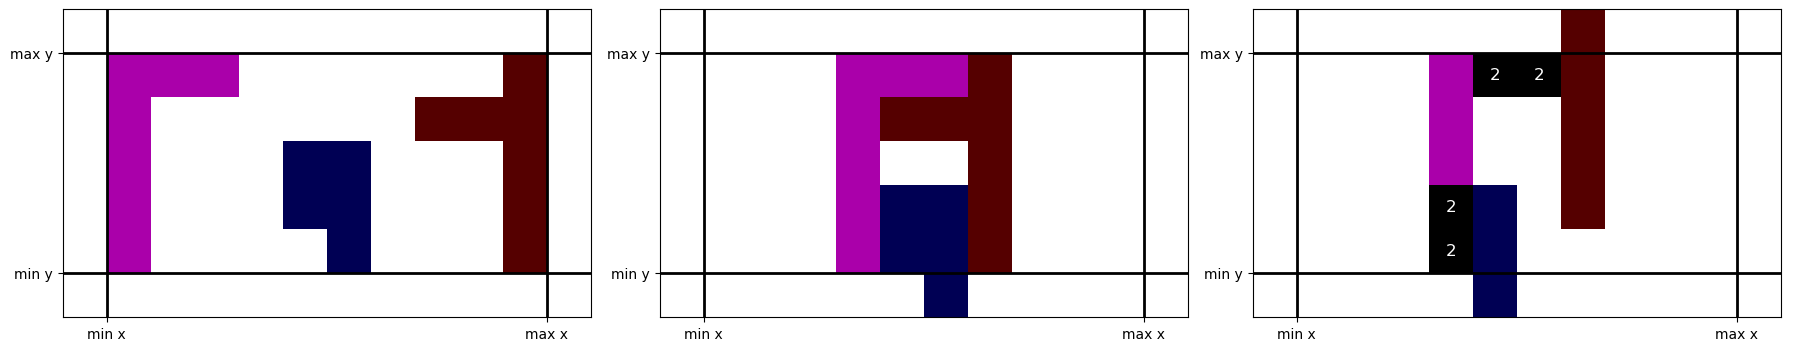

The first solution, being the only valid one, would have had the highest fitness out of these three in assignments 1a and 1b. The second solution is clearly much closer to an optimal solution, yet it would have had an arbitrarily poor fitness because one cell is out-of-bounds (making it invalid). The third solution, though it occupies the same length of stock as the second, is blatantly worse because it has more violations. Despite this, they would have both had the same fitness. Clearly, it's possible to assign meaningful fitness values to invalid solutions, allowing us to compare them (to valid solutions and to other invalid solutions), even though our previous definition of fitness failed to do so. 

To reiterate, if you had to use one of these examples as a solution, *without making any changes*, the only correct choice is the first one; the other two are invalid and do not actually solve the problem. However, if you had to use one of these examples *as a template for making new solutions*, then the second example is probably the best. Of these three, it is the closest one in the search landscape to optimal **valid** solutions. While it is **not** a valid solution on its own, it is still useful as genetic material in an EA (it would be a very good parent). This introduces a critical idea: there can be a difference between how well a solution actually solves the problem, versus how much we want it to survive and reproduce during a run of our EA!

## unconstrained_fitness_function
In Assignment 1a, you used `base_fitness_function` to evaluate solutions. That function returned a `dict` containing a fitness value. The fitness value was the length of stock available minus the length used, unless the solution was invalid, in which case it was an arbitrary negative value (`failure_fitness` in the config).

To properly implement your constraint satisfaction EA, we will be using `unconstrained_fitness_function`, which has slightly different behavior. You are free to compare and contrast the two functions, located in `cutting_stock/fitness_functions.py`, if you wish. In short, `unconstrained_fitness_function` returns a `dict` with three values:

* `'base fitness'` - The same value as `'fitness'` from `base_fitness_function`: length available minus length used for valid solutions, otherwise `failure_fitness` for invalid solutions. It has simply been renamed to remind you that we will be using it differently (you can't mindlessly reuse your existing code!).
* `'unconstrained fitness'` - The fitness value a solution would have if constraints are ignored: length available minus length used, for all solutions. Obviously, if a solution is valid (i.e., it violates no constraints), this is the same as its base fitness.
* `'violations'` - A nonnegative integer that represents the number of constraint violations in the solution. This is the number of cells that are out-of-bounds, plus the number of overlaps. If a solution is valid, it obviously has zero violations.

The following cell demonstrates how to obtain these values using `unconstrained_fitness_function`:

Base fitness: -50
Violations: 39
Penalized fitness: 15.6953125
Visualization:


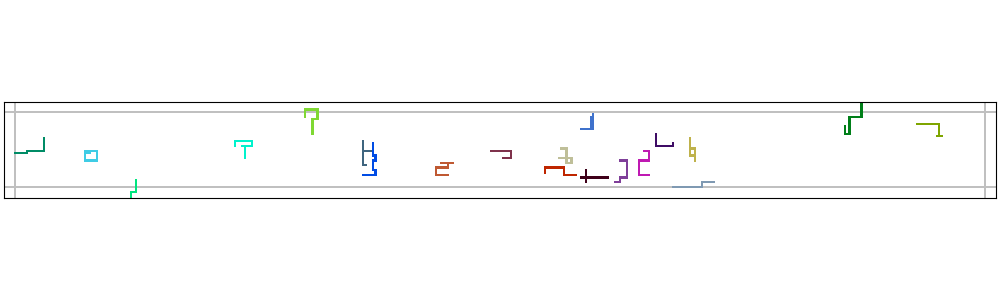

In [7]:
config = read_config('configs/1c/green_config.txt', globals(), locals())

# Used in calculating some values below; we'll discuss this later.
penalty_coefficient = config['problem']['penalty_coefficient']

# Make a random solution
test_solution = LinearGenotype()
test_solution.random_initialization(**config['problem'])

# Evaluate the solution
output = unconstrained_fitness_function(test_solution.genes, **config['problem'])

# Assign member variables based on the evaluation
test_solution.base_fitness = output['base fitness']
test_solution.violations = output['violations']
test_solution.fitness = output['unconstrained fitness'] - test_solution.violations * penalty_coefficient

# Print statements & visualization for tutorial
print('Base fitness:', test_solution.base_fitness)
print('Violations:', test_solution.violations)
print('Penalized fitness:', test_solution.fitness)
print('Visualization:')
visualize(test_solution.genes, **config['problem'])

del config, penalty_coefficient, test_solution, output

Note how we've assigned three member variables:
* `base_fitness` - The same thing as plain-old fitness from 1a and 1b, but we can think about it in a new way: `base_fitness` is how well the solution actually solves the problem, **NOT** necessarily how much we want it to survive and reproduce.
* `violations` - The number of constraint violations in the solution.
* `fitness` - The solution's penalized fitness. We calculate and assign `test_solution.fitness` using the solution's unconstrained fitness, its number of constraint violations, and a configured penalty coefficient (more on that in a bit). Since your selection algorithms were written to use each individual's `fitness` member variable, this is the variable that will actually affect your EA's search. In other words: `fitness` now represents how much we want an individual to survive and reproduce, **NOT** necessarily how well it actually solves the problem.

To be abundantly clear: **it is invalid to directly compare different types of fitness in your statistical analysis!** We will discuss this in more detail later in the notebook. For now, just know that storing all these different values in your individuals will make analysis more intuitive later on.

Now, let's look at how `fitness` was calculated: `unconstrained_fitness - violations * penalty_coefficient`. We are taking `unconstrained_fitness` (a solution's fitness if we ignore the constraints), and subtracting a penalty from it. This is why we say we are using a "penalty function", and why we call the new `fitness` a solution's "penalized fitness". The penalty is calculated as `violations * penalty_coefficient`, i.e., the number of times a solution violated the constraints multiplied by a (configurable) coefficient.

The choice of penalty coefficient is very important, since it lets us fine-tune how severely a solution is penalized for each violation; we will discuss it in greater detail when it comes time to tune your parameters.

Now that we've demonstrated how to calculate these values, it's your turn to write a function that evaluates an input population and assigns the above members to each individual. Complete the `unconstrained_population_evaluation` function inside `stock_population_evaluation.py`. This function should be pretty similar to the `base_population_evaluation` function you wrote for Assignment 1b, but notice the addition of the `penalty_coefficient` parameter.

The following cell will test your implementation by doing a full run of random search.

Average penalized fitness of population: 28.854574453125
Best penalized fitness in population: 225.6171875
Average base fitness of population: -49.98152
Best base fitness in population: 61
Number of valid solutions: 24
Visualizing solution with the best penalized fitness:


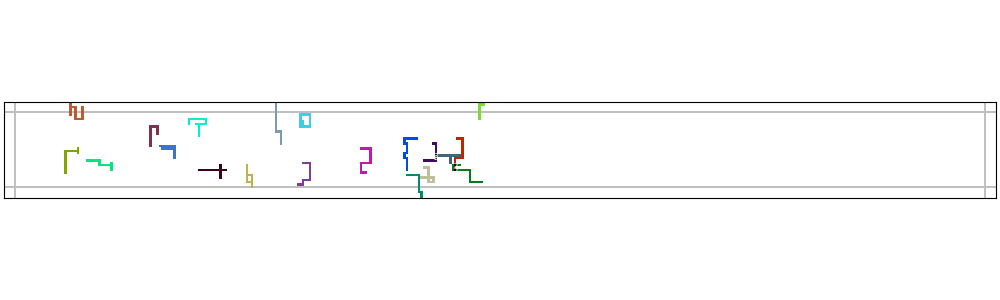

Visualizing solution with the best base fitness:


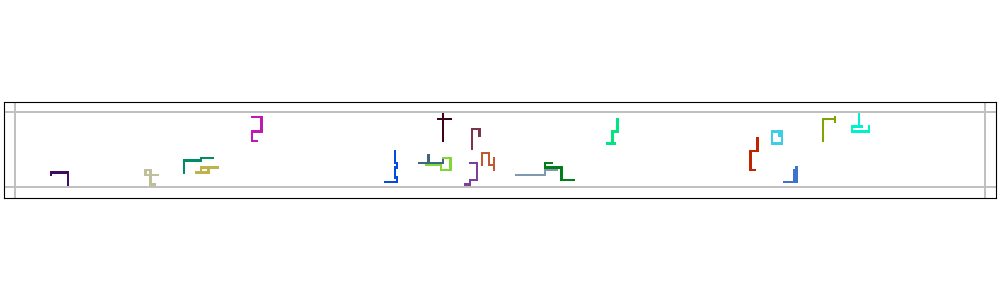

In [8]:
config = read_config('configs/1c/green_config.txt', globals(), locals())

example_population = LinearGenotype.initialization(100_000, **config['problem'])

# Note explicitly initializing to None is unnecessary in general
# We only do it here to test that you've actually set these values
for individual in example_population:
    individual.base_fitness = None
    individual.violations = None
    individual.fitness = None

# Calling your function to test things out
unconstrained_population_evaluation(example_population, **config['problem'])

no_base = [individual.base_fitness for individual in example_population].count(None)
no_violations = [individual.violations for individual in example_population].count(None)
no_penalized = [individual.fitness for individual in example_population].count(None)

failed = no_base or no_violations or no_penalized

if not failed:
    penalized_fitnesses = [individual.fitness for individual in example_population]
    print('Average penalized fitness of population:', statistics.mean(penalized_fitnesses))
    print('Best penalized fitness in population:', max(penalized_fitnesses))

    base_fitnesses = [individual.base_fitness for individual in example_population]
    print('Average base fitness of population:', statistics.mean(base_fitnesses))
    print('Best base fitness in population:', max(base_fitnesses))
    
    print('Number of valid solutions:', [individual.violations for individual in example_population].count(0))
    
    print('Visualizing solution with the best penalized fitness:')
    best_penalized = max(example_population, key=lambda x:x.fitness)
    visualize(best_penalized.genes, **config['problem'])

    print('Visualizing solution with the best base fitness:')
    best_base = max(example_population, key=lambda x:x.base_fitness)
    visualize(best_base.genes, **config['problem'])

    del penalized_fitnesses, base_fitnesses, best_penalized, best_base

else:
    print('Something was left as None. Ensure the entire population is evaluated then execute this cell again.')
    print('Individuals with unassigned base fitness:', no_base)
    print('Individuals with unassigned violations:', no_violations)
    print('Individuals with unassigned fitness:', no_penalized)

del config, example_population, no_base, no_violations, no_penalized, failed

## Assembling your EA
Now you get to use the framework you implemented in Assignment 1b to build a constraint satisfaction EA! Note that this can be nearly identical to the function from Assignment 1b's notebook, with a couple key differences. First, make sure you're calling `unconstrained_population_evaluation()` where you were previously calling `base_population_evaluation()`. Beyond that, the data we ask you to collect has changed somewhat:

1. (Same as 1b) Call `hist.add(solution.fitness)` once on every solution
2. (**NEW**) Call `base_hist.add(solution.base_fitness)` once on every solution
3. (**NEW**) Call `violation_hist.add(solution.violations)` once on every solution
4. (**NEW**) Return the highest **base** fitness `LinearGenotype` as `best_solution`
   * Again, this is global, and not just the best from your final generation
5. (Same as 1b) Update your EA's `evaluations` member every time you evaluate individuals
   * Make sure to do this before the call to `log_penalized_stats()`
6. (**NEW**) Call your EA's `log_penalized_stats()` method after each generation (including the initial population)
    * This is the same as in 1b, just switching the method from `log_base_stats()`
7. (Same as 1b) Return the mean and max fitness in the adult population at the end of each generation (including the initial population) as `mean_fit_per_gen` and `max_fit_per_gen`
    * This is penalized fitness, so just the `solution.fitness` member variable -- you can reuse code from 1b without changes
8. (**NEW**) Return the mean and max **base** fitness in the adult population at the end of each generation (including the initial population) as `mean_base_per_gen` and `max_base_per_gen`
9. (**NEW**) Return the proportion of valid solutions in the adult population at the end of each generation (including the initial population) as `valid_per_gen`
    * Note we want the proportion; calculate this by counting the number of valid solutions and dividing by `mu`
10. (Same as 1b) Return the cumulative evaluation count at the end of each generation (including the initial population) as `evaluation_counts`

Implement the function for one run of your constraint satisfaction EA in the following cell:

In [55]:
from math import inf

def constraint_satisfaction_run(num_evaluations, config):
    # Initialize a PenaltyHistogramMaker for tracking penalized fitness
    hist = PenaltyHistogramMaker()

    # Initialize a HistogramMaker for tracking base fitness
    base_hist = HistogramMaker(**config['problem'])

    # Initialize a InvalidityHistogramMaker for tracking violations
    violation_hist = InvalidityHistogramMaker()

    # Starting at -inf is a good way to keep track of the best fitness
    best_base_fitness = -inf

    # Assign your highest BASE fitness LinearGenotype to this variable
    best_solution = None

    # Assign the mean penalized fitness at each generation to this variable
    mean_fit_per_gen = [] 

    # Assign the max penalized fitness at each generation to this variable
    max_fit_per_gen = []

    # Assign the mean base fitness at each generation to this variable
    mean_base_per_gen = []

    # Assign the max base fitness at each generation to this variable
    max_base_per_gen = []

    # Assign the proportion of valid individuals at each generation to this variable
    valid_per_gen = []

    # Assign the evaluation count at each generation to this variable
    evaluation_counts = []
    
    # Initialize the EA, including an unevaluated population of size mu
    ea = BaseEvolutionPopulation(**config['ea'], **config)

    # Evaluate the initial population
    unconstrained_population_evaluation(ea.population, **config['problem'])
    
    for individual in ea.population:
        hist.add(individual.fitness)
        base_hist.add(individual.base_fitness)
        violation_hist.add(individual.violations)

    ea.evaluations = len(ea.population)
    ea.log_penalized_stats()

    while ea.evaluations < num_evaluations:
        print(ea.evaluations, end=' ')
        
        children = ea.generate_children()
        unconstrained_population_evaluation(children, **config['problem'])
        
        for child in children:
            hist.add(child.fitness)
            base_hist.add(child.base_fitness)
            violation_hist.add(child.violations)
        
        ea.evaluations += len(children)
        
        ea.population += children
        ea.survival()
        
        population_valid = 0
        population_total_fitness = 0.0
        population_total_base_fitness = 0.0
        population_max_fitness = float('-inf')
        population_max_base_fitness = float('-inf')
        population_best_individual = None
        
        for individual in ea.population:
            if individual.base_fitness > config['problem']['failure_fitness']:
                population_valid += 1
            
            population_total_fitness += individual.fitness
            population_total_base_fitness += individual.base_fitness
            
            if individual.fitness > population_max_fitness:
                population_max_fitness = individual.fitness
            
            if individual.base_fitness > population_max_base_fitness:
                population_max_base_fitness = individual.base_fitness
                population_best_individual = individual
        
        if population_max_base_fitness > best_base_fitness:
            best_base_fitness = population_max_base_fitness
            best_solution = population_best_individual
        
        population_size = len(ea.population)
        mean_fitness = population_total_fitness / population_size
        mean_base_fitness = population_total_base_fitness / population_size
        
        mean_fit_per_gen.append(mean_fitness)
        mean_base_per_gen.append(mean_base_fitness)
        max_fit_per_gen.append(population_max_fitness)
        max_base_per_gen.append(population_max_base_fitness)
        evaluation_counts.append(ea.evaluations)
        valid_per_gen.append(population_valid / population_size)
        
        ea.log_penalized_stats()

    # This will print outputs if it looks like anything has gone wrong.
    analyze_constraint_satisfaction_log(ea.log, num_evaluations)

    return best_solution, mean_fit_per_gen, max_fit_per_gen, \
           mean_base_per_gen, max_base_per_gen, valid_per_gen, \
           evaluation_counts, hist, base_hist, violation_hist, ea.log


Now run the next cell to test your function. This may take a minute or two to run. **If you ever change the function in the previous cell, make sure to execute that cell again so the changes get loaded by the interpreter!** Otherwise, the changes won't take effect in other cells.

In [ ]:
num_evaluations = 100_000
config = read_config('configs/1c/green_config.txt', globals(), locals())

# Testing one run of your EA (don't worry if the results are very poor, you'll improve it later on!)
(
    best_solution,
    mean_fit_per_gen,
    max_fit_per_gen,
    mean_base_per_gen,
    max_base_per_gen,
    valid_per_gen,
    evaluation_counts,
    hist,
    base_hist,
    violation_hist,
    log
) = constraint_satisfaction_run(num_evaluations, config)

# Save the logged values to a file for you to view
with open('example_log.txt', 'w') as f:
    f.write(''.join(line + '\n' for line in log))

print('Best solution fitness:', best_solution.fitness)
print('Best solution base fitness:', best_solution.base_fitness)
print('Best solution looks like:')
visualize(best_solution.genes, **config['problem'])

print('Penalized fitness histogram:')
hist.get_plot('Distribution of Penalized Fitnesses Over 1 Run').show()

print('Base fitness histogram:')
base_hist.get_plot('Distribution of Base Fitnesses Over 1 Run').show()

print('Violation histogram:')
violation_hist.get_plot('Distribution of Violations Over 1 Run').show()

del config, num_evaluations, best_solution, mean_fit_per_gen, \
    max_fit_per_gen, mean_base_per_gen, max_base_per_gen, valid_per_gen, \
    evaluation_counts, hist, base_hist, violation_hist, log

If your results are dissapointingly bad, don't worry; that's expected. You'll need to tune your EA later in order to obtain decent results, and we will walk you through this process later in this notebook.

Did the log analyzer print any warnings about your algorithm at the start of the previous cell's output? If it did, this likely represents a bug in your implementation. Read the warning carefully, and try to figure out what went wrong before proceeding. Note we wrote your EA's log to `example_log.txt`, which may help in diagnosing errors.

## Experiment
Just like in previous assignments, now that you've implemented a function for a single run, it's time to implement a function for a multi-run experiment. The data you need to collect this time around is:

1. (**NEW**) The highest **base** fitness value encountered in each run (one number per run) as `best_per_run`
    * Note your run function's `best_solution` should have been the highest base fitness solution; thus, the highest base fitness value from a run is just `best_solution.base_fitness`
2. (**NEW**) The highest **base** fitness `LinearGenotype` found by any of the runs as `best_solution`
3. (Same as 1b) The three histogram objects representing the data collected from the runs (**this is already done for you!**)
4. (Same as 1b) The mean and max fitness in the adult population at each generation (including the initial population) in each run as `mean_per_gen_per_run` and `max_per_gen_per_run`
    * This is penalized fitness, so just the `solution.fitness` member variable -- you can reuse code from 1b without changes
5. (**NEW**) The mean and max base fitness in the adult population at each generation (including the initial population) in each run as `mean_base_per_gen_per_run` and `max_base_per_gen_per_run`
6. (**NEW**) The proportion of valid solutions in the adult population at each generation (including the initial population) in each run as `valid_per_gen_per_run`
7. (Same as 1b) The number of evaluations at the end of each generation (including the initial population) as `evaluation_counts`

Now, implement code for a multi-run experiment in the following cell. **As a reminder, if you get pickle encoding errors, you need to re-execute the following cell.** And again, if you run into issues due to low RAM, you can manually lower the number of parallel runs by passing the `processes` parameter to `multiprocessing.Pool()`.

In [45]:
from stock_population_evaluation import unconstrained_population_evaluation
from linear_genotype import LinearGenotype
from base_evolution import BaseEvolutionPopulation
from selection import *

# Like in past assignments, we use this function to avoid pickling errors.
# It will call your run function, serialize the best solution,
# and return the string and its non-gene members instead of the entire LinearGenotype.
def multiprocess_helper(num_evaluations, config):
    (
        best_solution,
        mean_fit_per_gen,
        max_fit_per_gen,
        mean_base_per_gen,
        max_base_per_gen,
        valid_per_gen,
        evaluation_counts,
        hist,
        base_hist,
        violation_hist,
        log
    ) = constraint_satisfaction_run(num_evaluations, config)
    return best_solution.serialize(), best_solution.fitness, best_solution.base_fitness, \
           best_solution.violations, mean_fit_per_gen, max_fit_per_gen, mean_base_per_gen, \
           max_base_per_gen, valid_per_gen, evaluation_counts, hist, base_hist, violation_hist, log


def constraint_satisfaction_experiment(num_runs, num_evaluations, config):
    # We handle these for you; don't worry about the histograms here
    hist_per_run = []
    base_hist_per_run = []
    violation_hist_per_run = []

    # We handle this for you; don't worry about the logs here
    logs = []

    # Assign the highest BASE fitness value seen in each run to this variable
    # i.e., a list/tuple of num_runs numbers
    best_per_run = []

    # Assign your best LinearGenotype to this variable
    # It should be the highest BASE fitness solution seen across all runs
    best_solution = None
    best_base_fitness = float('-inf')

    # Use these to store the mean fitness and max fitness at each generation from each run
    # This should be a 2-dimensional data structure, for example:
    # mean_per_gen_per_run[r] is the mean_fit_per_gen returned from run r
    # Therefore:
    # mean_per_gen_per_run[r][g] is the mean fitness from run r at generation g
    mean_per_gen_per_run = [[] for _ in range(num_runs)]
    max_per_gen_per_run = [[] for _ in range(num_runs)] 

    # These are similar to the above, just using base fitness
    mean_base_per_gen_per_run = [[] for _ in range(num_runs)] 
    max_base_per_gen_per_run = [[] for _ in range(num_runs)] 

    # This is similar to the above, just using the proportion of valid solutions
    valid_per_gen_per_run = [[] for _ in range(num_runs)] 

    # Assign the evaluation counts at the end of each generation to this variable
    # Since this should be the same for every run in an experiment, you can just
    # return the evaluation_counts from one of the runs
    evaluation_counts = None

    # This executes your runs in parallel, using the multiprocess_helper function
    # IMPORTANT: If you are running out of RAM, as mentioned in the above text,
    # you can pass 'processes' keyword argument to multiprocessing.Pool() here
    with multiprocessing.Pool() as pool:
        args = [(num_evaluations, config)] * num_runs
        run_results = list(pool.starmap(multiprocess_helper, args))


    # Iterate over the completed runs' results
    for i in range(num_runs):
        # This gets the data from run i,
        # deserializes its best solution as run_best_solution,
        # collects the histograms (don't worry about the histograms),
        # and collects the log (don't worry about the log)
        (
            run_serialization,
            run_solution_fitness,
            run_solution_base,
            run_solution_violations,
            mean_fit_per_gen,
            max_fit_per_gen,
            mean_base_per_gen,
            max_base_per_gen,
            valid_per_gen,
            run_evaluation_counts,
            hist,
            base_hist,
            violation_hist,
            log
        ) = run_results[i]
        run_best_solution = LinearGenotype()
        run_best_solution.deserialize(run_serialization)
        run_best_solution.fitness = run_solution_fitness
        run_best_solution.base_fitness = run_solution_base
        run_best_solution.violations = run_solution_violations
        hist_per_run.append(hist)
        base_hist_per_run.append(base_hist)
        violation_hist_per_run.append(violation_hist)
        logs.append(log)
        
        # TODO: Use run_best_solution, mean_fit_per_gen,
        #       max_fit_per_gen, mean_base_per_gen, max_base_per_gen,
        #       valid_per_gen, and run_evaluation_counts
        #       to collect data in the variables described
        #       at the start of this function.
        best_per_run.append(run_best_solution.base_fitness)
        if run_best_solution.base_fitness > best_base_fitness:
            best_base_fitness = run_best_solution.base_fitness
            best_solution = run_best_solution
            
        mean_per_gen_per_run[i] = mean_fit_per_gen
        max_per_gen_per_run[i] = max_fit_per_gen
        mean_base_per_gen_per_run[i] = mean_base_per_gen
        max_base_per_gen_per_run[i] = max_base_per_gen 
        
        
        valid_per_gen_per_run[i] = valid_per_gen
        
        if evaluation_counts is None:
            evaluation_counts = run_evaluation_counts
    
    # Merge the histograms from each run
    merged_hist = PenaltyHistogramMaker.merge(hist_per_run)
    merged_base_hist = HistogramMaker.merge(base_hist_per_run)
    merged_violation_hist = InvalidityHistogramMaker.merge(violation_hist_per_run)

    return best_per_run, best_solution, mean_per_gen_per_run, max_per_gen_per_run, \
           mean_base_per_gen_per_run, max_base_per_gen_per_run, valid_per_gen_per_run, \
           evaluation_counts, merged_hist, merged_base_hist, merged_violation_hist, logs

Let's run a quick test in the next cell to make sure everything works, before we embark on a full experiment. As a reminder, **if you change the previous cell, make sure to re-run that cell to save the changes to your function!** We'll do 3 runs:

In [ ]:
example_num_runs = 3
example_num_evaluations = 100_000
config = read_config('configs/1c/green_config.txt', globals(), locals())

(
    example_best_per_run,
    example_best_solution,
    example_mean_per_gen_per_run,
    example_max_per_gen_per_run,
    example_mean_base_per_gen_per_run,
    example_max_base_per_gen_per_run,
    example_valid_per_gen_per_run,
    example_evaluation_counts,
    example_hist,
    example_base_hist,
    example_violation_hist,
    example_logs
) = constraint_satisfaction_experiment(example_num_runs,
                                       example_num_evaluations,
                                       config)

print('Correct number of best fitnesses?', example_num_runs == len(example_best_per_run))
print('Correct number of runs in mean per gen data?', example_num_runs == len(example_mean_per_gen_per_run))
print('Correct number of runs in best per gen data?', example_num_runs == len(example_max_per_gen_per_run))
print('Correct number of runs in mean base per gen data?', example_num_runs == len(example_mean_base_per_gen_per_run))
print('Correct number of runs in best base per gen data?', example_num_runs == len(example_max_base_per_gen_per_run))
print('Correct number of runs in valid per gen data?', example_num_runs == len(example_valid_per_gen_per_run))

print('Best base fitness per run:', example_best_per_run)

print('Best solution fitness:', example_best_solution.fitness)
print('Best solution base fitness:', example_best_solution.base_fitness)
print('Best solution looks like:')
visualize(example_best_solution.genes, **config['problem'])

print('Penalized fitness histogram:')
example_hist_plot = example_hist.get_plot(f'Distribution of Penalized Fitnesses Over {example_num_runs} Runs')
example_hist_plot.show()

print('Base fitness histogram:')
example_base_hist_plot = example_base_hist.get_plot(f'Distribution of Base Fitnesses Over {example_num_runs} Runs')
example_base_hist_plot.show()

print('Violation histogram:')
example_violation_hist_plot = example_violation_hist.get_plot(f'Distribution of Violations Over {example_num_runs} Runs')
example_violation_hist_plot.show()

Just like in previous assignments, we've provided a function to save your experimental data for you:

In [17]:
def save_data(best_per_run, best_solution, mean_data, max_data, mean_base_data, max_base_data, \
              valid_data, eval_counts, hist, base_hist, violation_hist, logs, subdir, config):
    subdir.mkdir(parents=True, exist_ok=True)

    with open(subdir / 'best_per_run.txt', 'w') as f:
        for result in best_per_run:
            f.write(str(result) + '\n')

    with open(subdir / 'best_solution.txt', 'w') as f:
        f.write(best_solution.serialize())

    visualize(best_solution.genes, path=subdir / 'best_solution.png', **config['problem'])

    with open(subdir / 'mean_per_gen_per_run.txt', 'w') as f:
        f.write(str(mean_data))

    with open(subdir / 'max_per_gen_per_run.txt', 'w') as f:
        f.write(str(max_data))

    with open(subdir / 'mean_base_per_gen_per_run.txt', 'w') as f:
        f.write(str(mean_base_data))

    with open(subdir / 'max_base_per_gen_per_run.txt', 'w') as f:
        f.write(str(max_base_data))

    with open(subdir / 'valid_per_gen_per_run.txt', 'w') as f:
        f.write(str(valid_data))

    with open(subdir / 'evaluation_counts.txt', 'w') as f:
        f.write(str(eval_counts))

    hist.save_to_file(subdir / 'histogram.txt')
    base_hist.save_to_file(subdir / 'base_histogram.txt')
    violation_hist.save_to_file(subdir / 'violation_histogram.txt')

    logdir = subdir / 'logs'
    logdir.mkdir(exist_ok=True)
    for i in range(len(logs)):
        with (logdir / f'{i}.txt').open('w') as f:
            f.write(''.join(line + '\n' for line in logs[i]))

    print('Data saved to', subdir)

Run the following cell and navigate to `data/1c/example/` to inspect the results and make sure everything looks correct.

In [26]:
config = read_config('configs/1c/green_config.txt', globals(), locals())
save_data(example_best_per_run,
          example_best_solution,
          example_mean_per_gen_per_run,
          example_max_per_gen_per_run,
          example_mean_base_per_gen_per_run,
          example_max_base_per_gen_per_run,
          example_valid_per_gen_per_run,
          example_evaluation_counts,
          example_hist,
          example_base_hist,
          example_violation_hist,
          example_logs,
          Path('./data/1c/example/'),
          config)
example_hist_plot.savefig('data/1c/example/histogram.png')
example_base_hist_plot.savefig('data/1c/example/base_histogram.png')
example_violation_hist_plot.savefig('data/1c/example/violation_histogram.png')

Data saved to data/1c/example


### Evals-vs-fitness Plot
We ask you to generate an evals-vs-fitness plot similar to the one you generated in Assignment 1b, except this time you must additionally plot the average mean and max base fitness and the average proportion of valid solutions. The code for this should be fairly simple to implement based on what you did in Assignment 1b. Here's an example of such a plot:

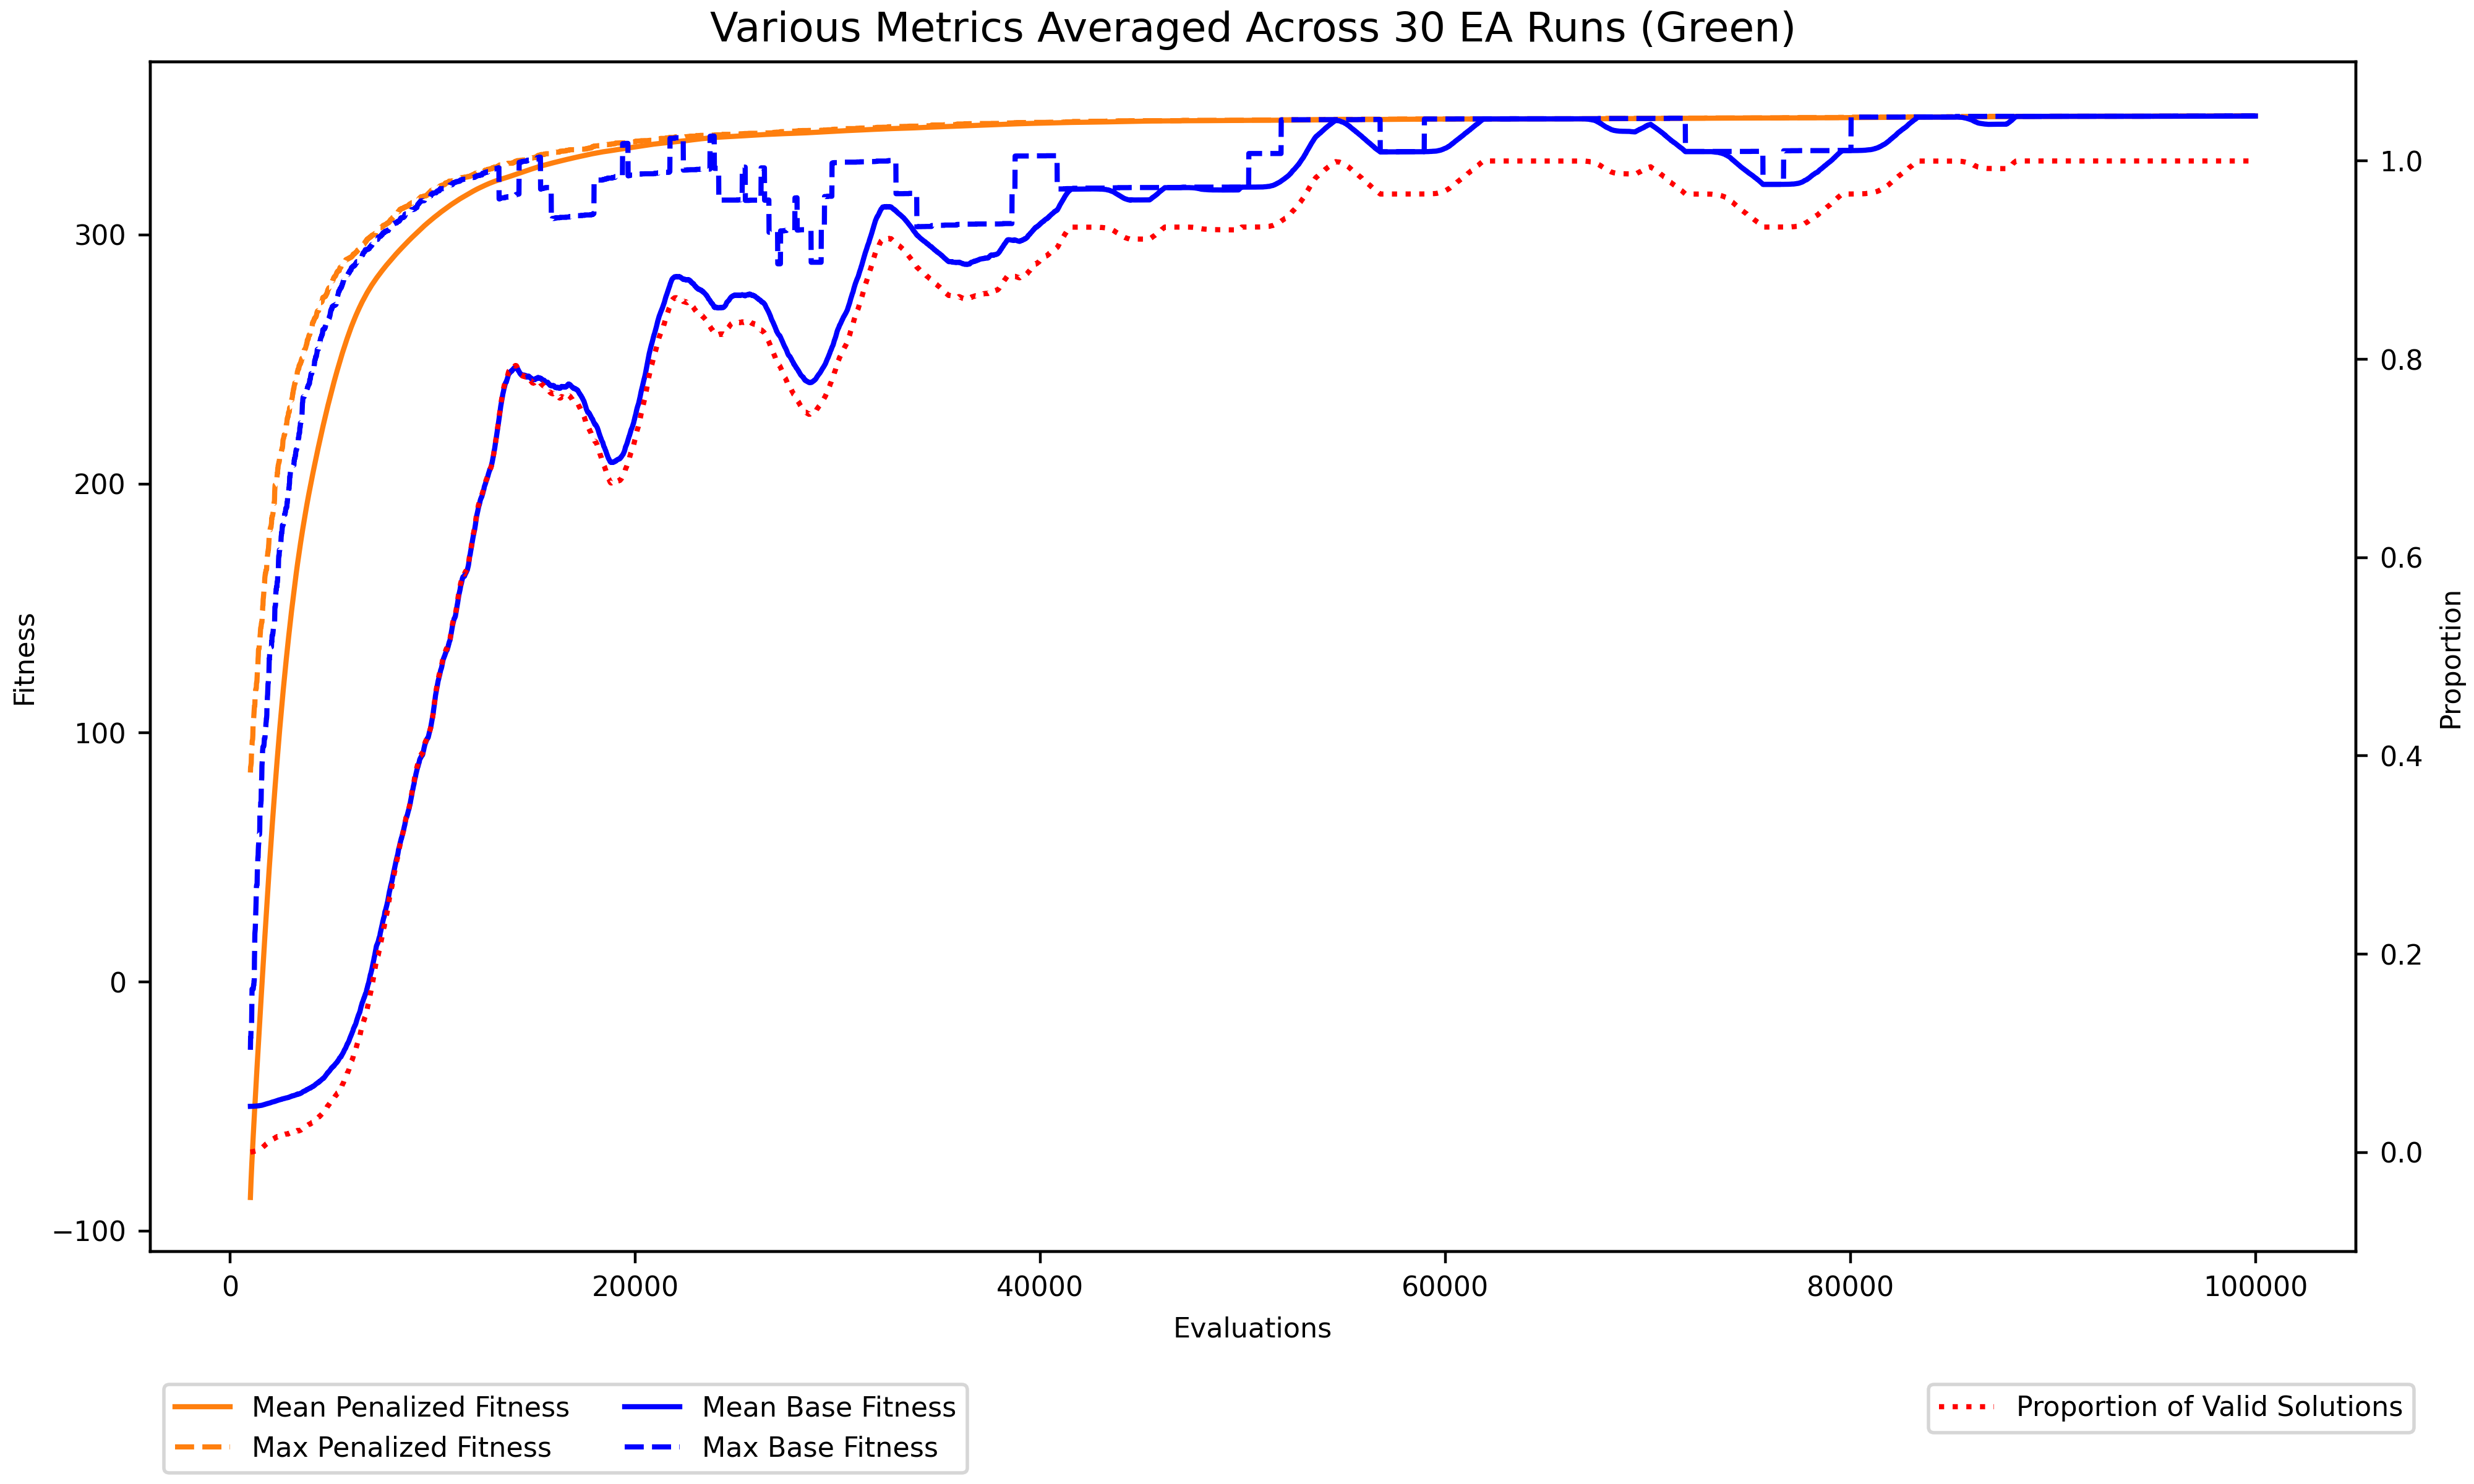

In the following cell, finish implementing the function to generate this plot:

In [48]:
def evals_vs_fitness(mean_per_gen_per_run, max_per_gen_per_run, mean_base_per_gen_per_run, \
                     max_base_per_gen_per_run, valid_per_gen_per_run, evaluation_counts, title, filename):
    print(len(valid_per_gen_per_run[0]))
    print(len(max_base_per_gen_per_run[0]))
    print(len(max_per_gen_per_run[0]))
    # Using the input mean_per_gen_per_run and max_per_gen_per_run values,
    # store the y-values for mean fitness in average_means,
    # and the y-values for best fitness in average_maxes.
    average_means = [statistics.mean([gen[i] for gen in mean_per_gen_per_run]) for i in range(len(mean_per_gen_per_run[0]))]
    average_maxes = [statistics.mean([gen[i] for gen in max_per_gen_per_run]) for i in range(len(max_per_gen_per_run[0]))]

    # This is similar to the above, but with the values for base fitness.
    average_base_means = [statistics.mean([gen[i] for gen in mean_base_per_gen_per_run]) for i in range(len(mean_base_per_gen_per_run[0]))]
    average_base_maxes = [statistics.mean([gen[i] for gen in max_base_per_gen_per_run]) for i in range(len(max_base_per_gen_per_run[0]))]

    # This is similar to the above, but with the values for valid proportions.
    average_valid_proportion = [statistics.mean([gen[i] for gen in valid_per_gen_per_run]) for i in range(len(valid_per_gen_per_run[0]))]
    
    # This will make the plot for you
    with plt.ioff():
        fig, ax = plt.subplots(figsize=(10.0, 6.0))
        ax.set(xlabel='Evaluations', title=title)
        ax2 = ax.twinx()
        ax.plot(evaluation_counts, average_means, '-', color='tab:orange')
        ax.plot(evaluation_counts, average_maxes, '--', color='tab:orange')
        ax.plot(evaluation_counts, average_base_means, 'b-')
        ax.plot(evaluation_counts, average_base_maxes, 'b--')
        ax.legend(['Mean Penalized Fitness', 'Max Penalized Fitness', \
                   'Mean Base Fitness', 'Max Base Fitness'], \
                  loc='upper left', bbox_to_anchor=(0, -0.1), ncols=2)
        ax.set(ylabel='Fitness')
        ax2.plot(evaluation_counts, average_valid_proportion, 'r:')
        ax2.set_ylim([-0.1, 1.1])
        ax2.set(ylabel='Proportion')
        ax2.legend(['Proportion of Valid Solutions'], \
                   loc='upper left', bbox_to_anchor=(0.8, -0.1))
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = True
        fig.savefig(filename)
        fig.show()

With that function completed, run the following cell to generate your evals-vs-fitness plot. We'll save it to `data/1c/example/plot.png`, as well as display it. If you haven't modified the config, this plot may look a little strange; if the lines are mostly horizontal, that is completely fine. Still, you should double-check that the plot agrees with the data that you collected.

In [ ]:
evals_vs_fitness(example_mean_per_gen_per_run,
                 example_max_per_gen_per_run,
                 example_mean_base_per_gen_per_run,
                 example_max_base_per_gen_per_run,
                 example_valid_per_gen_per_run,
                 example_evaluation_counts,
                 'Various Metrics Averaged Across a 3-run Experiment',
                 'data/1c/example/plot.png')

Since you will be running many different experiments, we will define one more function to reduce boilerplate. This function encapsulates both running an experiment and saving all the necessary data.

In [49]:
def experiment_and_save(num_runs, num_evaluations, config, data_dir, problem_name):
    (
        best_per_run,
        best_solution,
        mean_per_gen_per_run,
        max_per_gen_per_run,
        mean_base_per_gen_per_run,
        max_base_per_gen_per_run,
        valid_per_gen_per_run,
        evaluation_counts,
        hist,
        base_hist,
        violation_hist,
        logs
    ) = constraint_satisfaction_experiment(num_runs,
                                           num_evaluations,
                                           config)

    save_data(best_per_run,
              best_solution,
              mean_per_gen_per_run,
              max_per_gen_per_run,
              mean_base_per_gen_per_run,
              max_base_per_gen_per_run,
              valid_per_gen_per_run,
              evaluation_counts,
              hist,
              base_hist,
              violation_hist,
              logs,
              data_dir,
              config)

    visualize(best_solution.genes, **config['problem'])
    
    fig = hist.get_plot(f'Distribution of Penalized Fitnesses Over {num_runs} EA Runs ({problem_name})')
    fig.savefig(data_dir / 'histogram.png')
    fig.show()

    base_fig = base_hist.get_plot(f'Distribution of Base Fitnesses Over {num_runs} EA Runs ({problem_name})')
    base_fig.savefig(data_dir / 'base_histogram.png')
    base_fig.show()

    violation_fig = violation_hist.get_plot(f'Distribution of Violations Over {num_runs} EA Runs ({problem_name})')
    violation_fig.savefig(data_dir / 'violation_histogram.png')
    violation_fig.show()
    
    evals_vs_fitness(mean_per_gen_per_run,
                     max_per_gen_per_run,
                     mean_base_per_gen_per_run,
                     max_base_per_gen_per_run,
                     valid_per_gen_per_run,
                     evaluation_counts,
                     f'Various Metrics Averaged Across {num_runs} EA Runs ({problem_name})',
                     data_dir / 'plot.png')

### Tuning Your EA
**Note**: For this assignment, we will only be experimenting using the hard problem instance. The easy problem instance is too, well, easy, for constraint satisfaction to make a large difference: the base EA was already pretty good at finding solutions, so there isn't much room for improvement. The hard problem instance, on the other hand, should effectively showcase the benefits of constraint satisfaction on appropriate problems.

Now that you've finished implementing everything you need for experimentation, you can prepare to perform a 30-run experiment. Before the experiment, of course, you should tune your parameters. But first, we want you to answer the following questions before you conduct your tuning:

**Question 1** (0.5%): On the hard problem instance, what proportion of random solutions are valid? State your answer as a decimal with at least five significant figures. As a reminder, we asked you this same question on both previous assignments.

$\frac{\text{96,949 valid solutions}}{\text{300,000 total solutions}} = 0.32316$

**Question 2** (0.5%): Explain why your answer to Question 1 motivates a very large (`10,000+`) value for `mu` ($\mu$) when running your Assignment 1b EA implementation on the hard problem instance.

Since there are so many invalid solutions, we need to heavily explore what valid solutions exist before attempting to make any children.

**Question 3** (1%): Describe one way in which having such a large value for `mu` ($\mu$) can negatively impact your EA's performance.

Having a large $\mu$ can potentially be damaging to performance because it does not leave very many evals left to exploit good solutions found in the initial population

**Question 4** (4%): Do the changes we have made to our definition of fitness in this assignment make smaller values of `mu` ($\mu$) more reasonable? Why or why not?

I would argue that since we now have a better fitness function, it makes sense to have a smaller $\mu$. Having a large $\mu$ is useful because it allows the EA to explore lots of possible options to build off from. By having a large $\mu$ we get to know, of those initial options, which ones are better than others. This means that the EA has a much better understanding of the quality of its initial solutions. Therefore, by having a better fitness function, we reduce the quanity of options needed to get a quality solution. 

**Question 5** (1.5%): Explain the behavior you expect to see if the penalty coefficient is negative.

If the penality coefficient was negative, that would mean that we would be optimizing for the worst possible solution. Every violation in the solution would increase the fitness, thereby encouraging more violations to occur in future generations. 

**Question 6** (1%): Explain the behavior you expect to see if the penalty coefficient is zero.

If the penalty coefficient was zero, the fitness function would be exactly like 1B. There would be no additional penalty for each violation. Therefore, tracking the total number of violations would be useless.

**Question 7** (1.5%): Explain the behavior you expect to see if the penalty coefficient is extremely high (much higher than any possible value for `base_fitness`).

Having too high of a penalty coeffecient means that the almost really good solutions with one of two violations get massively penalized. This is bad because those types of solutions are the ones that are very close to the final solutions that we want to obtain. 

As usual, the following cell defines a function to make tuning convenient:

In [63]:
def tuning_experiment(num_runs, num_evaluations, config_path, problem_name):
    config = read_config(config_path, globals(), locals())
    config_text = config_path.read_text()

    # Set up a new subdirectory for us to save artifacts to
    base_subdir = Path('./tuning/') / config_path.parent.name / config_path.stem
    base_subdir.mkdir(parents=True, exist_ok=True)
    children = set(int(child.stem) for child in base_subdir.iterdir())
    if children:
        index = max(children) + 1
    else:
        index = 1
    subdir = base_subdir / str(index)

    # Run your EA experiment and save the data
    experiment_and_save(num_runs, num_evaluations, config, subdir, problem_name)

    # Make a copy of the config
    config_copy = subdir / config_path.name
    config_copy.write_text(config_path.read_text())

    # Print average best base fitness
    with open(subdir / 'best_per_run.txt', 'r') as f:
        best_per_run = [int(line) for line in f.readlines()]
    print('Average best base fitness:', statistics.mean(best_per_run))

Now, tune the parameters in `configs/1c/green_config.txt` (including `penalty_coefficient`). You may wish to use your tuned parameters from Assignment 1b's hard problem instance as a starting point. For this assignment, we require that you tune your penalty function EA such that it outperforms your 1b EA's performance on the hard problem instance by a statistically significant margin. Pay particular attention to the evals-vs-fitness plot and the new histograms: these can be extremely valuable for informing you about how your penalty coefficient is impacting the search.

Note that the penalty coefficient can be any positive real number. If you want to use a non-integer coefficient, we strongly recommend writing it as a rational fraction: you should use `1/3` rather than `0.333333`, to help avoid floating-point errors.

2000020000  2000020000  20000 20300 20300 20300 20300 20300 20600 20600 20600 20600 20600 20900 20900 20900 20900 20900 21200 21200 21200 21200 21200 21500 21500 21500 21500 21500 21800 21800 21800 21800 21800 22100 22100 22100 22100 22100 22400 22400 22400 22400 22400 22700 22700 22700 22700 22700 23000 23000 23000 23000 23000 23300 23300 23300 23300 23300 23600 23600 23600 23600 23600 23900 23900 23900 23900 23900 24200 24200 24200 24200 24200 24500 24500 24500 24500 24500 24800 24800 24800 24800 24800 25100 25100 25100 25100 25100 25400 25400 25400 25400 25400 25700 25700 25700 25700 25700 26000 26000 26000 26000 26000 26300 26300 26300 26300 26300 26600 26600 26600 26600 26600 26900 26900 26900 26900 26900 27200 27200 27200 27200 27200 27500 27500 27500 27500 27500 27800 27800 27800 27800 27800 28100 28100 28100 28100 28100 28400 28400 28400 28400 28400 28700 28700 28700 28700 28700 29000 29000 29000 29000 29000 29300 29300 29300 29300 29300 29600 29600 29600 29600 29600 29900 2990

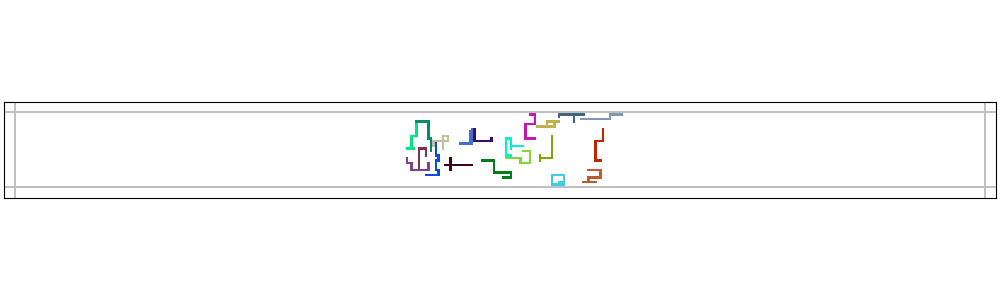

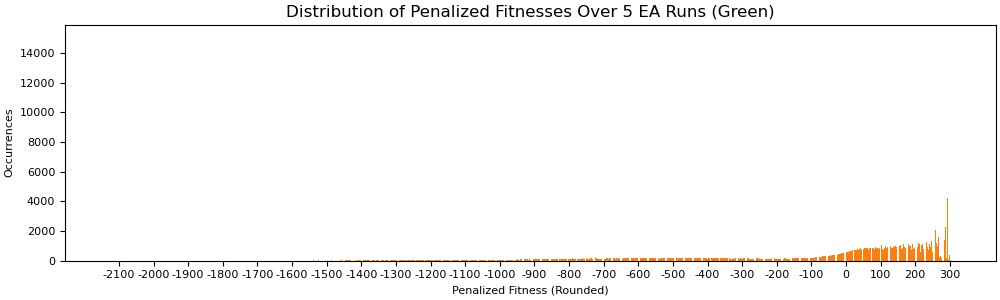

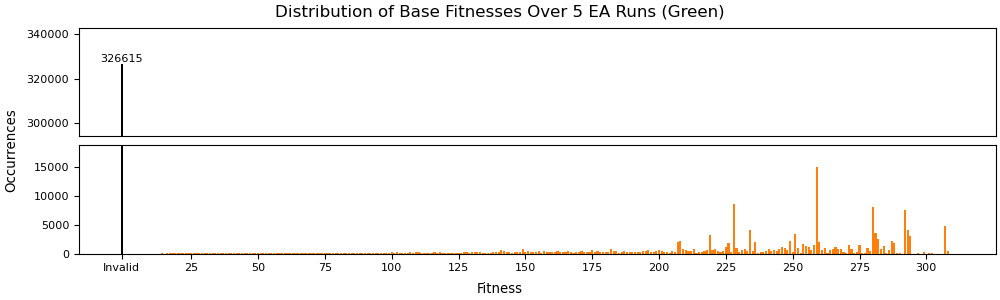

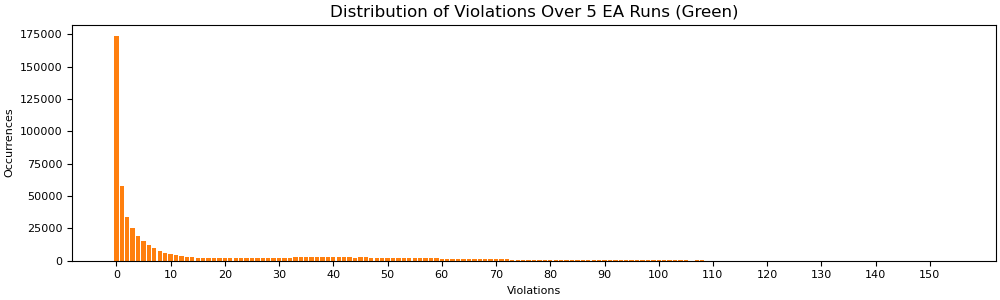

267
267
267


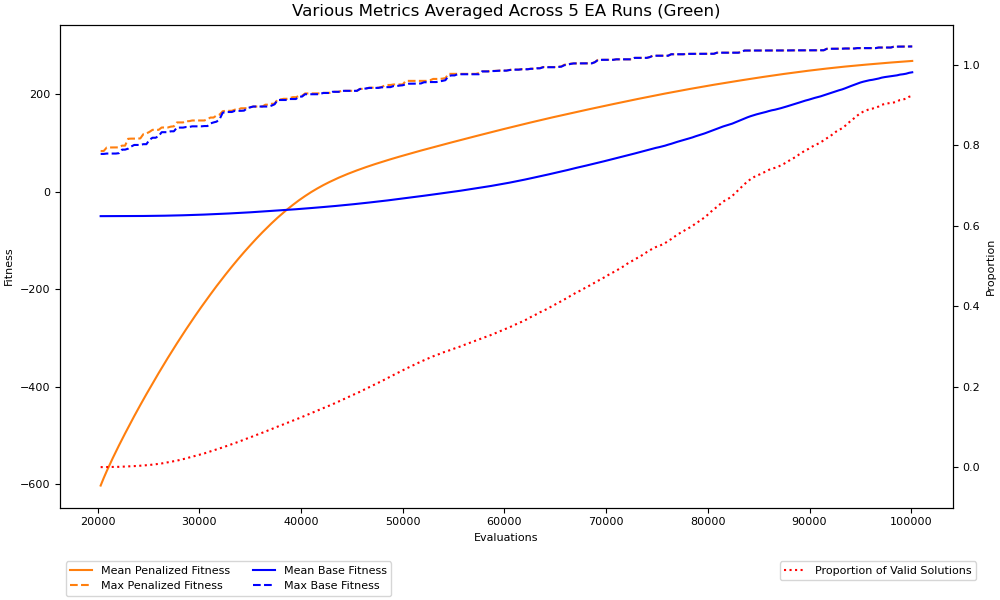

Average best base fitness: 298


In [67]:
tuning_runs = 5 # Note you can increase this with no time loss if you have more CPU cores
num_evaluations = 100_000
green_config_path = Path('./configs/1c/green_config.txt')

tuning_experiment(tuning_runs, num_evaluations, green_config_path, 'Green')

## Running Your EA
With your tuning complete, you can execute the following cell to run your full experiment!

20000 2000020000  20000 20000 20000 20000 20000 20000 20000 20000 20000 20150 20150 20150 20150 20150 2015020150  20150 20150 20150 20150 20150 20300 20300 20300 20300 20300 20300 20300 20300 2030020300  20300 20300 20450 20450 20450 20450 20450 20450 20450 20450 20450 20450 20450 20450 20600 20600 20600 20600 20600 20600 20600 20600 2060020600  20600 20600 20750 20750 20750 20750 20750 20750 20750 20750 2075020750  20750 20750 20900 20900 20900 20900 20900 20900 20900 20900 20900 20900 20900 20900 21050 2105021050  21050 21050 21050 21050 21050 21050 21050 21050 21050 21200 21200 21200 21200 21200 21200 21200 21200 21200 21200 21200 21200 21350 21350 21350 21350 2135021350  21350 21350 21350 21350 21350 21350 21500 21500 21500 21500 21500 21500 21500 21500 21500 21500 21500 21500 21650 21650 21650 21650 21650 21650 21650 21650 21650 21650 21650 21650 21800 21800 21800 21800 21800 21800 21800 21800 21800 21800 21800 21800 21950 21950 21950 21950 21950 21950 21950 21950 21950 21950 2195

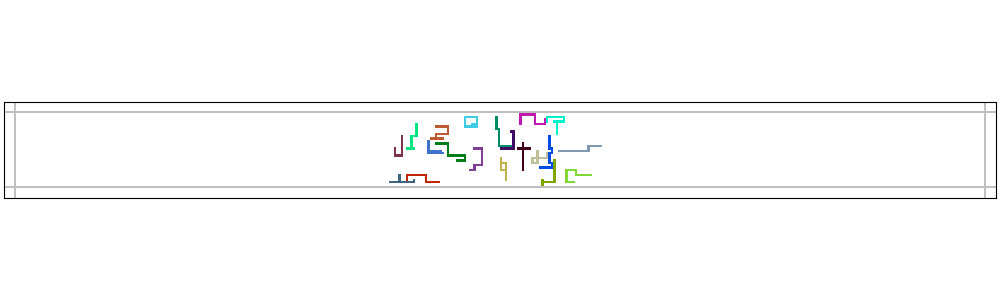

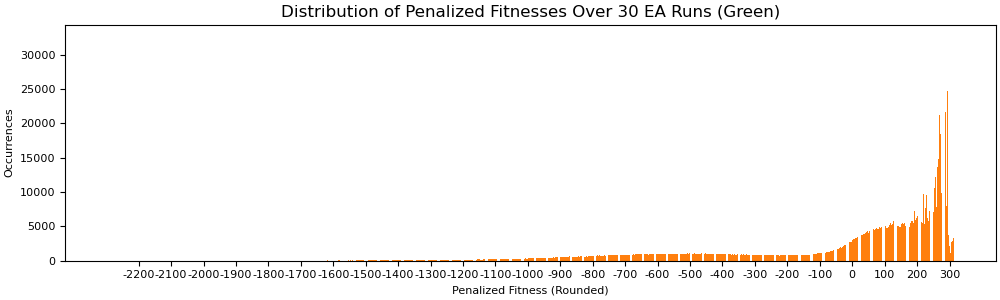

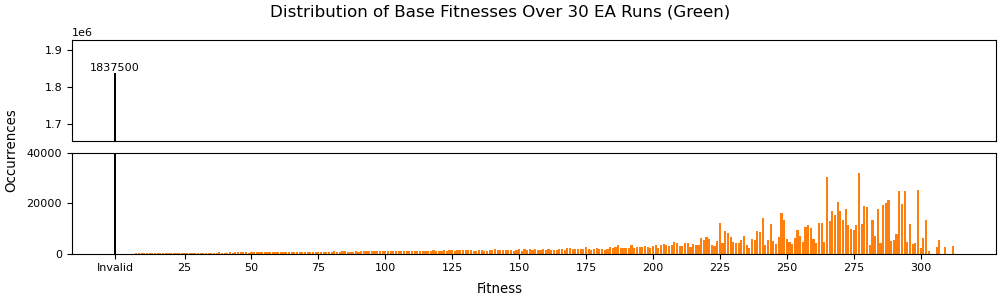

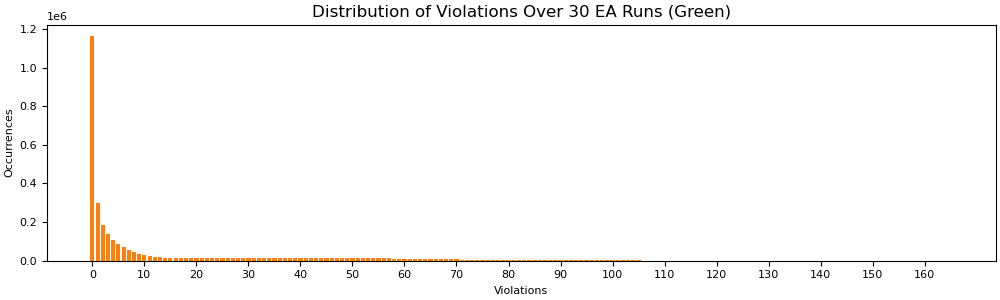

534
534
534


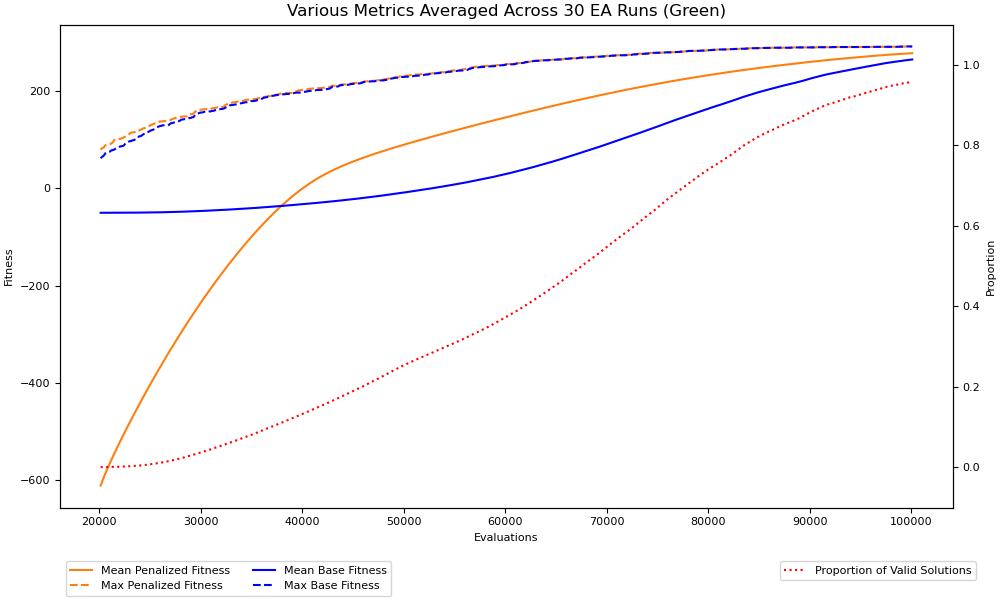

In [68]:
num_runs = 30
num_evaluations = 100_000
green_config = read_config('configs/1c/green_config.txt', globals(), locals())
green_data_path = Path('./data/1c/green/')

experiment_and_save(num_runs,
                    num_evaluations,
                    green_config,
                    green_data_path,
                    'Green')

## Report
You should now have all of the experimental data required to complete the report described in the assignment document. There is still one piece missing for the GREEN deliverable, however: statistical analysis.

### Statistical Analysis
Statistical analysis should consist of a comparison between best per-run fitness values of your Assignment 1c EA search with the data your EA generated during Assignment 1b's GREEN deliverable on the hard problem instance.

**If you received feedback indicating you lost points in algorithmic/programming/tuning in Assignment 1b's GREEN deliverable**, once you have fixed these issues (which should have been before running your above experiment!) you should rerun your 1b EA to generate appropriate data for analysis. If you didn't receive such feedback, then you can use your data from Assignment 1b as-is.

This time, we ask you to write the code for statistical analysis yourself, using our provided `run_stats()` function. To serve as an example, this was the function call we used in the last assignment to compare 1a's performance to 1b GREEN's performance on the easy problem instance:

```py
run_stats('data/1a/easy/best_per_run.txt', 'data/1b/easy_green/best_per_run.txt')
```

In [69]:
import scipy
import statistics

def run_stats(dataset1, dataset2):
    with open(dataset1, 'r') as f:
        data1 = [int(line) for line in f.readlines()]

    with open(dataset2, 'r') as f:
        data2 = [int(line) for line in f.readlines()]

    assert len(data1) == len(data2), 'Datasets do not have the same number of samples!'

    print('Number of samples:', len(data1))

    print(dataset1 + ' mean:', statistics.mean(data1))
    print(dataset1 + ' stdv:', statistics.stdev(data1))

    print(dataset2 + ' mean:', statistics.mean(data2))
    print(dataset2 + ' stdv:', statistics.stdev(data2))

    test_result = scipy.stats.ttest_ind(data1, data2, equal_var=False)
    print('p-value:', test_result.pvalue)

run_stats('data/1b/hard_green/best_per_run.txt', 'data/1c/green/best_per_run.txt')

Number of samples: 30
data/1b/hard_green/best_per_run.txt mean: 214.9
data/1b/hard_green/best_per_run.txt stdv: 31.70265952076663
data/1c/green/best_per_run.txt mean: 292.2
data/1c/green/best_per_run.txt stdv: 11.241548549603985
p-value: 8.778909489128499e-15


# Yellow Deliverable (Bonus for 5660 students, required for 6660 students)
If attempting the 1c yellow deliverable, perform your experiment and analysis below. You may add new cells, if you wish.

# Red Deliverable (Bonus)
If attempting the 1c red deliverable, perform your experiment and analysis below. You may add new cells, if you wish.